In [1]:
%matplotlib inline
%load_ext Cython
import matplotlib.pyplot as plt
import numpy as np
import numba as nb
import pandas as pd
import cython
from scipy.optimize import curve_fit

masses = {
    "P" : 0.93827203,
    "PIP" : 0.13957018,
    "KAON" : 0.493677
}

WARNING  Overriding pythran description with argspec information for: numpy.concatenate
WARNING  Overriding pythran description with argspec information for: numpy.empty_like


In [2]:
class SliceFitter:
    def __init__(hist_x, hist_y, x_range=(0, 4), y_range=(-5, 5)):
        pass

In [3]:
%%cython --annotate
import numpy as np
cimport numpy as cnp
from libc.math cimport sqrt
cimport cython

cdef float c_special_units = 29.9792458
cdef float MASS_PIP = 0.13957018


@cython.nonecheck(False)
@cython.cdivision(True)
cdef float dt_calc(float mass, float vertex, float momentum, float sc_t, float sc_r):
    if momentum == 0 or sc_t == 0 or sc_r == 0:
        return 100
    cdef float r_beta = 1.0 / sqrt(1.0 + (mass / momentum) * (mass / momentum))
    cdef float vt = sc_t - sc_r / (r_beta * c_special_units)
    
    return vertex - vt

@np.vectorize
def calc_dt(float mass, float vertex, float momentum, float sc_t, float sc_r):
    return dt_calc(mass, vertex, momentum, sc_t, sc_r)


In [4]:
data = pd.read_csv("/Users/tylern/Desktop/show/deltaT.dat")
print(len(data))
data = data.replace(0, np.nan)
data = data.dropna()
print(len(data))

268123
222745


In [5]:
data.head()

,sec,theta,phi,charge,vertex,p,sc_t,sc_r
0,4.0,0.761038,-1.76851,1.0,69.4602,1.79762,89.1317,515.934
2,3.0,0.695117,-0.57725,1.0,69.7951,2.05427,89.2427,529.012
3,1.0,0.808141,1.42165,1.0,54.5045,1.62006,73.8726,497.847
4,1.0,0.902803,1.45153,1.0,63.8317,1.15131,85.1396,477.482
5,6.0,0.829981,2.55678,1.0,59.7624,1.56238,79.1183,487.576


In [6]:
%time
for mass in masses:
    data[f"dt_{mass}"] = calc_dt(masses[mass], data.vertex, data.p, data.sc_t, data.sc_r)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


In [7]:
data = data.dropna()
#data = data[(data.theta < 1.0) & (np.abs(data.dt_PIP) < 1.2)]
data.head()

,sec,theta,phi,charge,vertex,p,sc_t,sc_r,dt_P,dt_PIP,dt_KAON
0,4.0,0.761038,-1.76851,1.0,69.4602,1.79762,89.1317,515.934,-0.258568,-2.409996,-1.824608
2,3.0,0.695117,-0.57725,1.0,69.7951,2.05427,89.2427,529.012,-0.048187,-1.760979,-1.299263
3,1.0,0.808141,1.42165,1.0,54.5045,1.62006,73.8726,497.847,-0.177658,-2.700195,-2.007797
4,1.0,0.902803,1.45153,1.0,63.8317,1.15131,85.1396,477.482,-0.761593,-5.264217,-3.978344
5,6.0,0.829981,2.55678,1.0,59.7624,1.56238,79.1183,487.576,-0.384708,-3.027351,-2.299526


In [8]:
def two_gauss(x, *p):
    A, mu, sigma, A2, mu2, sigma2 = p
    g1 = A*np.exp(-(x-mu)**2/(2.*sigma**2))
    g2 = A2*np.exp(-(x-mu2)**2/(2.*sigma2**2))
    return g1+g2

def gauss(x, *p):
    A, mu, sigma = p
    g1 = A*np.exp(-(x-mu)**2/(2.*sigma**2))
    return g1

def poly(x, a, b, c, d, e):
    y = a*x**4 + b*x**3 + c*x**2 + d*x + e
    return y


def get_slices(data, sec=1, charge=1, min_p = 0.0, max_p = 4.0, num_steps = 120, particle="dt_PIP", show=False):
    slices = []
    mom = np.linspace(min_p, max_p, num=num_steps, endpoint=True)
    if sec != 0:
        d = data[(data.charge == charge) & (data.sec == sec)]
    else:
        d = data[(data.charge == charge)]
    for m in range(len(mom[:-1])):
        _min = mom[m]
        _max = mom[m+1]
        slic = d[(d.p > _min) & (d.p <= _max)]
        if len(slic) > 100:
            if show:
                ydata, xdata, _ = plt.hist(slic[particle], bins=200, range=(-5,5))
            else:
                ydata, xdata = np.histogram(slic[particle], bins=200, range=(-5,5))
                
            xdata = (xdata[1:] + xdata[:-1])/2.0
            try:
                p0 = [1.0, 0.0, 0.01]
                param_bounds=((0,    -0.5,  0),
                              (np.inf,0.5,  1.0)
                             )
                popt, pcov = curve_fit(gauss, xdata, ydata, p0=p0, bounds=param_bounds, method="trf", maxfev=10000)

                if popt[2] > 0.4:
                    x2 = xdata[xdata>-0.8]
                    y2 = ydata[xdata>-0.8]
                    popt, pcov = curve_fit(gauss, x2, y2, p0=p0, bounds=param_bounds, method="trf", maxfev=10000)
                
                if show:
                    plt.plot(xdata, gauss(xdata, *popt), 'r-',
                        label='fit: A=%5.3f, mu=%5.3f, sigma=%5.3f' % tuple(popt))
                    plt.legend()
                slices.append([(_min+_max)/2.0, popt[1], popt[2]])
            except RuntimeError:
                try:
                    p0 = [1.0, 0.0, 0.01]
                    param_bounds=((0,    -0.5,  0),
                                  (np.inf,0.5,  0.5)
                             )
                    popt, pcov = curve_fit(gauss, xdata, ydata, p0=p0, 
                                           bounds=param_bounds, method="trf", maxfev=10000)
                    if show:
                        plt.plot(xdata, gauss(xdata, *popt), 'r-',
                             label='fit: A=%5.3f, mu=%5.3f, sigma=%5.3f' % tuple(popt))
                        plt.legend()
                        
                    if popt[2] < 1.0:
                        slices.append([(_min+_max)/2.0, popt[1], popt[2]])
                except RuntimeError:
                    pass
            else:
                pass
            
            if show:
                plt.show()
                
    return np.array(slices).T

In [9]:
slices = get_slices(data, min_p = 0.0, max_p = 2.5, num_steps = 250, show=False)

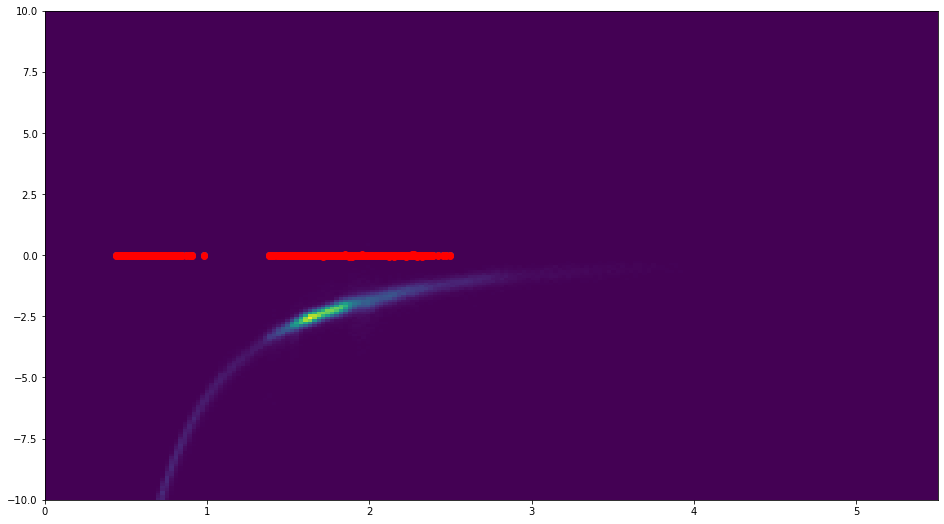

In [10]:
slice_p = slices[0]
mu = slices[1]
sigma = slices[2]

fig = plt.figure(figsize=(16,9))
plt.hist2d(data.p, data.dt_PIP, bins=200, range=((0, 5.5),(-10.0,10.0)))
plt.scatter(slice_p, mu)
plt.scatter(slice_p, mu+3*sigma, c='r')
plt.scatter(slice_p, mu-3*sigma, c='r')
plt.show()

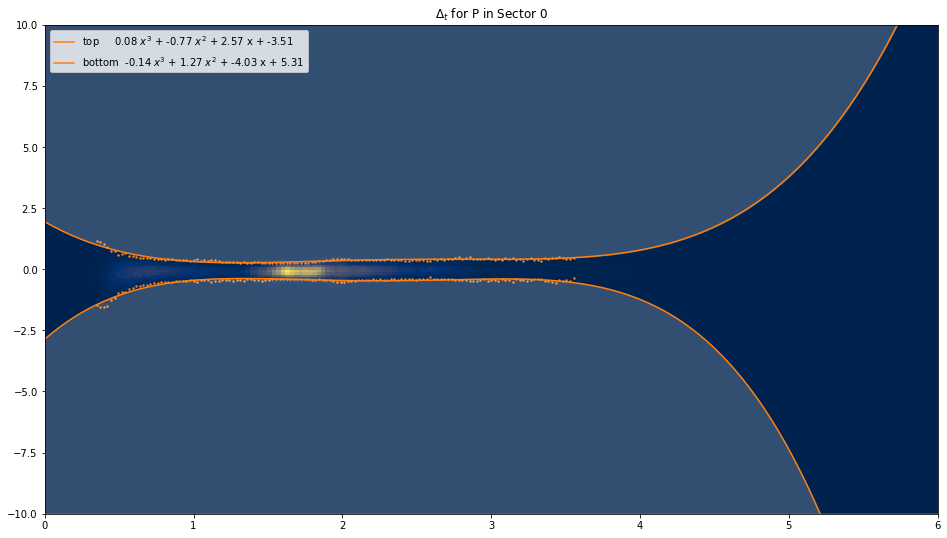

0 top P {0.08240030048909537,-0.7710826520788646,2.570661547673607,-3.509283013250415,1.9410227467899008}
0 bottom P {-0.1433929584211291,1.2741941832017054,-4.027205118341501,5.306509383159595,-2.863560530067931}


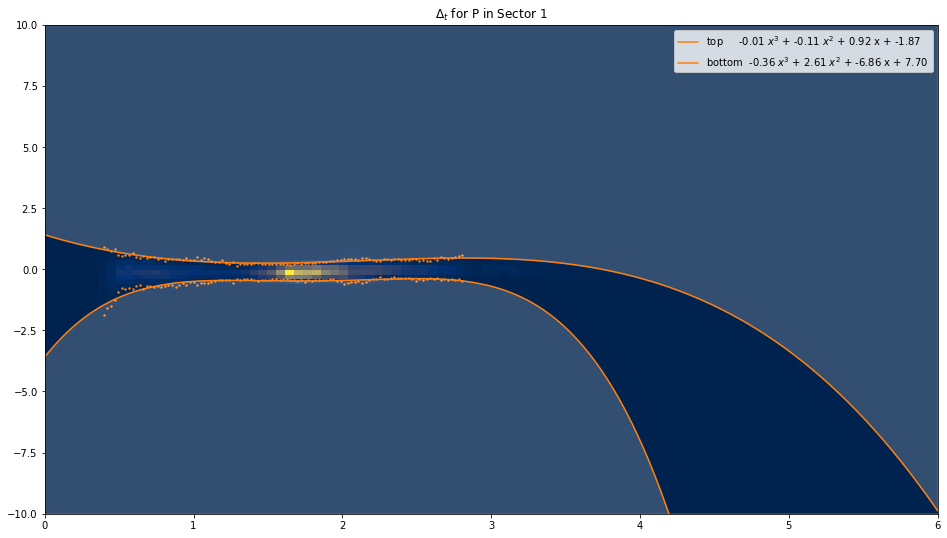

1 top P {-0.0065124963702305715,-0.11406298939635777,0.9169988905523422,-1.8682400348794563,1.4053568855136709}
1 bottom P {-0.3573423205331837,2.6088330005548177,-6.855217965695893,7.700115613437986,-3.5935485323229233}


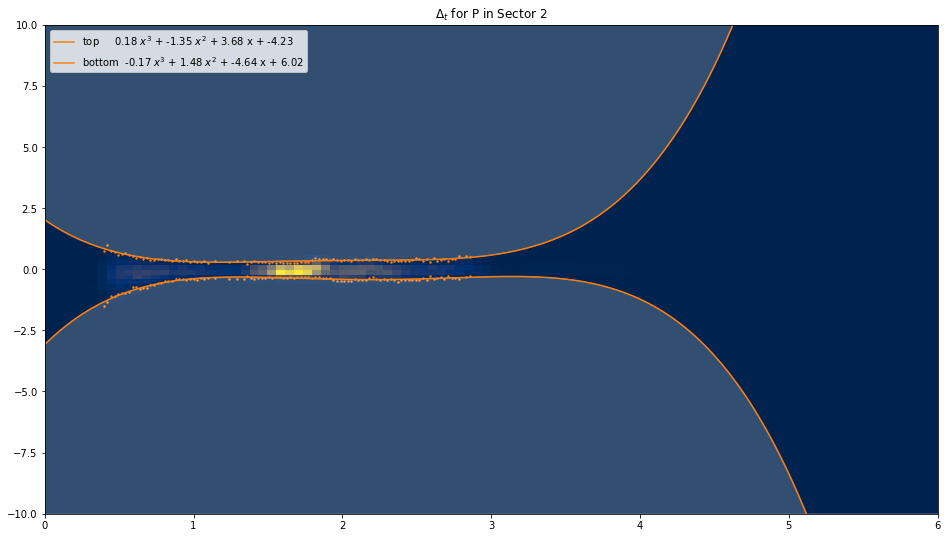

2 top P {0.1802062892969702,-1.3505991527368322,3.6785563134537838,-4.22724935296183,2.01789304187556}
2 bottom P {-0.16780380242540138,1.4839714950965868,-4.638920979254979,6.017159504736992,-3.08332209456534}


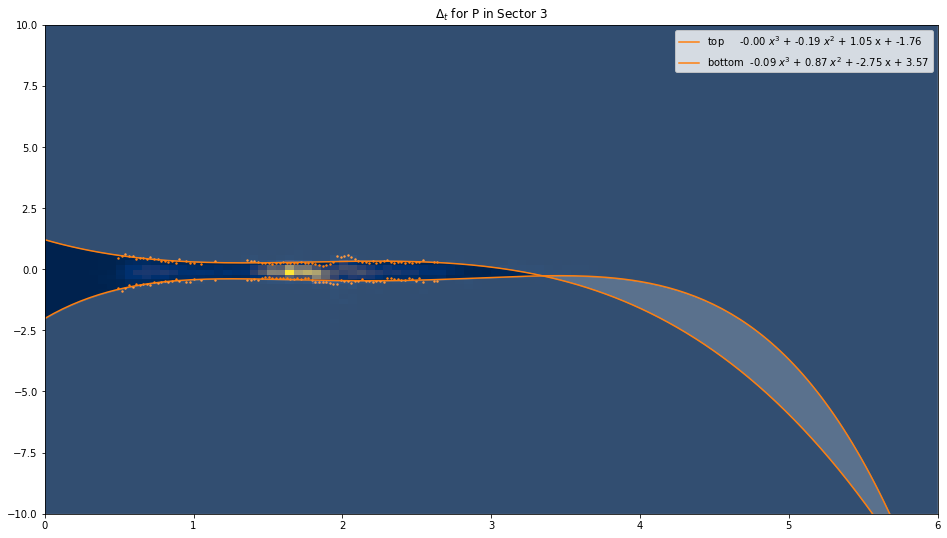

3 top P {-0.0005937638846724713,-0.19318375886258843,1.0479935269722116,-1.7629567909304504,1.2053862726658517}
3 bottom P {-0.09426039568777923,0.8656523324276623,-2.7526555476894816,3.5715141720257875,-2.016802037572125}


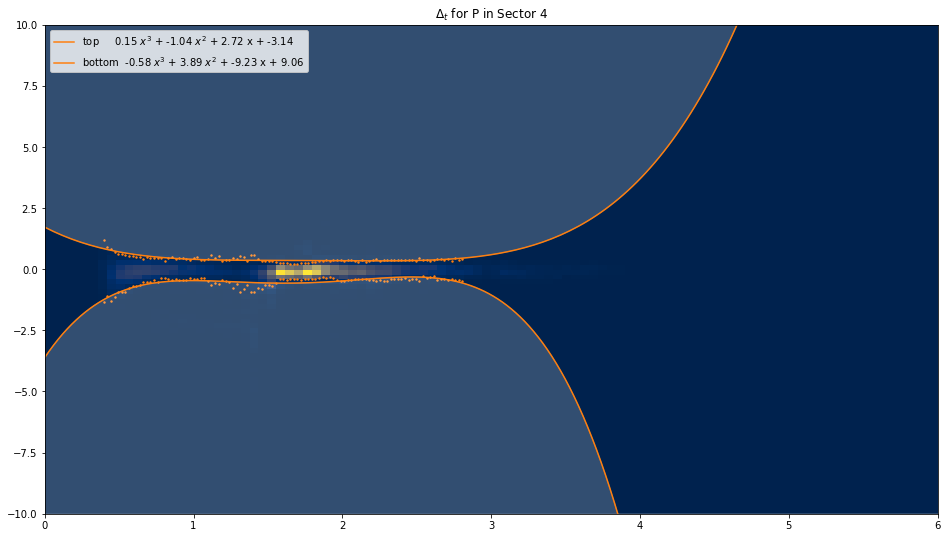

4 top P {0.14631613237013918,-1.0378778514615041,2.719508726516912,-3.1437001753500304,1.717765304238636}
4 bottom P {-0.5764339524654577,3.8933780431533513,-9.227554983518347,9.060355772380806,-3.6148891143887667}


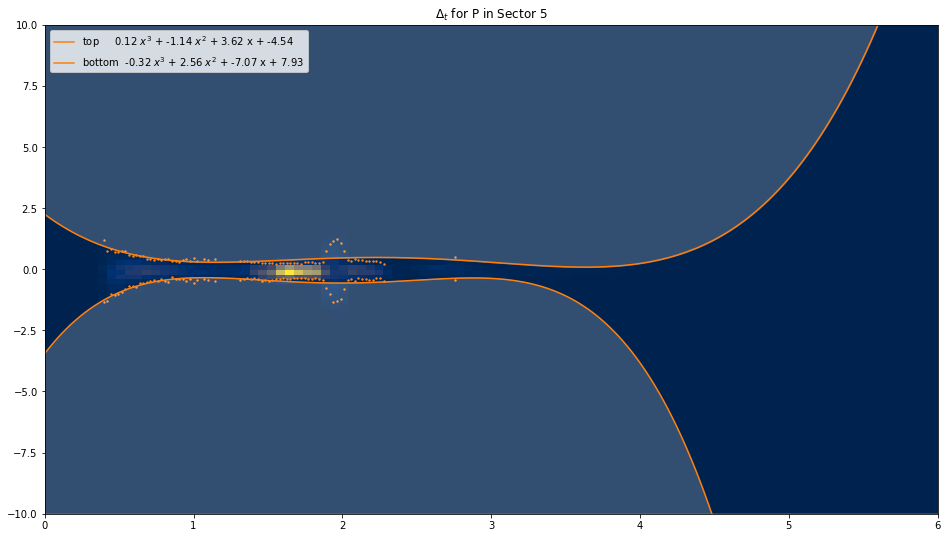

5 top P {0.12173767390146219,-1.1385209181802656,3.6164484396900276,-4.543313681124566,2.2437382893034292}
5 bottom P {-0.3233591087216686,2.559652780036158,-7.071061258058156,7.93184315615977,-3.449744959232331}


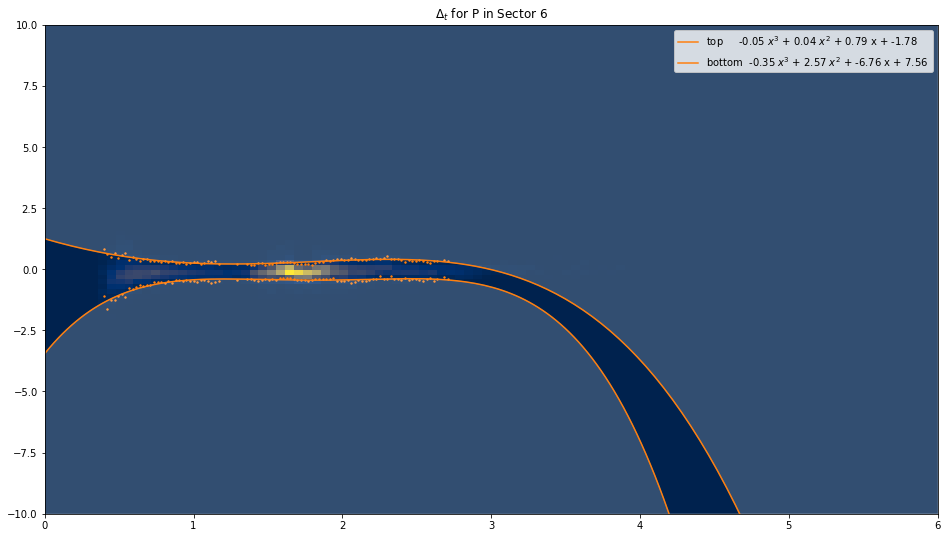

6 top P {-0.05121096926893374,0.041215480085096845,0.7896753210000116,-1.7772089507445266,1.2435605835894459}
6 bottom P {-0.3518739980347768,2.5684498099470257,-6.755223751722895,7.557707055460317,-3.451061689714594}


In [11]:
for part in ["dt_P"]:
    for i in range(0,7):
        n_sigma = 2
        slices = get_slices(data, min_p = 0.0, max_p = 6.0, num_steps = 250, sec=i, particle=part)
        slice_p = slices[0][slices[2] > 0.05]
        mu = slices[1][slices[2] > 0.05]
        sigma = slices[2][slices[2] > 0.05]

        fig = plt.figure(figsize=(16,9))
        plt.title(f"$\Delta_t$ for {part[3:]} in Sector {i}")
        if i != 0:
            plt.hist2d(data[data.sec == i].p, data[data.sec == i][part], bins=100, range=((0, 6.0),(-10.0,10.0)), cmap='cividis')
        else:
            plt.hist2d(data.p, data[part], bins=200, range=((0, 6.0),(-10.0,10.0)), cmap='cividis')
            
        #plt.scatter(slice_p, mu, s=2.0, c='#bcbd22')
        plt.scatter(slice_p, mu+n_sigma*sigma, s=2.0, c='#ff7f0e')
        plt.scatter(slice_p, mu-n_sigma*sigma, s=2.0, c='#ff7f0e')
        
        xdata = np.linspace(0,6.0,200)
        popt_top, pcov_top = curve_fit(poly, slice_p, mu+n_sigma*sigma)
        plt.plot(xdata, poly(xdata, *popt_top), c='#ff7f0e',
                 label=f'top\t{popt_top[0]:0.2f} $x^3$ + {popt_top[1]:0.2f} $x^2$ + {popt_top[2]:0.2f} x + {popt_top[3]:0.2f}')

        popt_bottom, pcov_bottom = curve_fit(poly, slice_p, mu-n_sigma*sigma)
        plt.plot(xdata, poly(xdata, *popt_bottom), c='#ff7f0e',
                 label=f'bottom\t{popt_bottom[0]:0.2f} $x^3$ + {popt_bottom[1]:0.2f} $x^2$ + {popt_bottom[2]:0.2f} x + {popt_bottom[3]:0.2f}')

        
        plt.fill_between(xdata, poly(xdata, *popt_top), 10, alpha=0.2, color='white')
        plt.fill_between(xdata, poly(xdata, *popt_bottom), -10, alpha=0.2, color='white')
        plt.legend()
        
        
        plt.show()
        
        print(f"{i} top {part[3:]} {{{popt_top[0]},{popt_top[1]},{popt_top[2]},{popt_top[3]},{popt_top[4]}}}")
        print(f"{i} bottom {part[3:]} {{{popt_bottom[0]},{popt_bottom[1]},{popt_bottom[2]},{popt_bottom[3]},{popt_bottom[4]}}}")
        

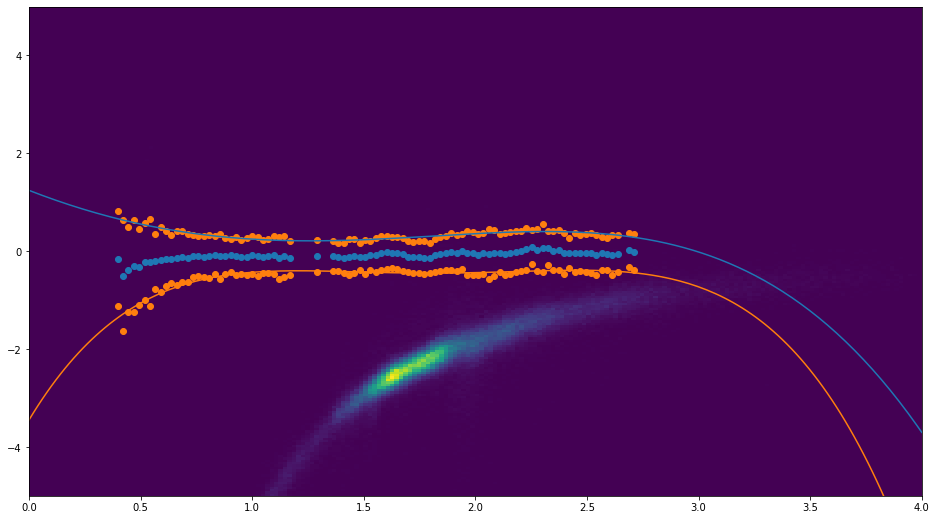

In [12]:
slice_p = slices[0]
mu = slices[1]
sigma = slices[2]

fig = plt.figure(figsize=(16,9))
plt.hist2d(data.p, data.dt_PIP, bins=200, range=((0, 4.0),(-5.0,5.0)))
plt.scatter(slice_p, mu)
plt.scatter(slice_p, mu+2*sigma, c='#ff7f0e')
plt.scatter(slice_p, mu-2*sigma, c='#ff7f0e')

popt, pcov = curve_fit(poly, slice_p, mu+2*sigma)
xdata = np.linspace(0,4,200)
plt.plot(xdata, poly(xdata, *popt))

popt, pcov = curve_fit(poly, slice_p, mu-2*sigma)
xdata = np.linspace(0,4,200)
plt.plot(xdata, poly(xdata, *popt))

plt.show()

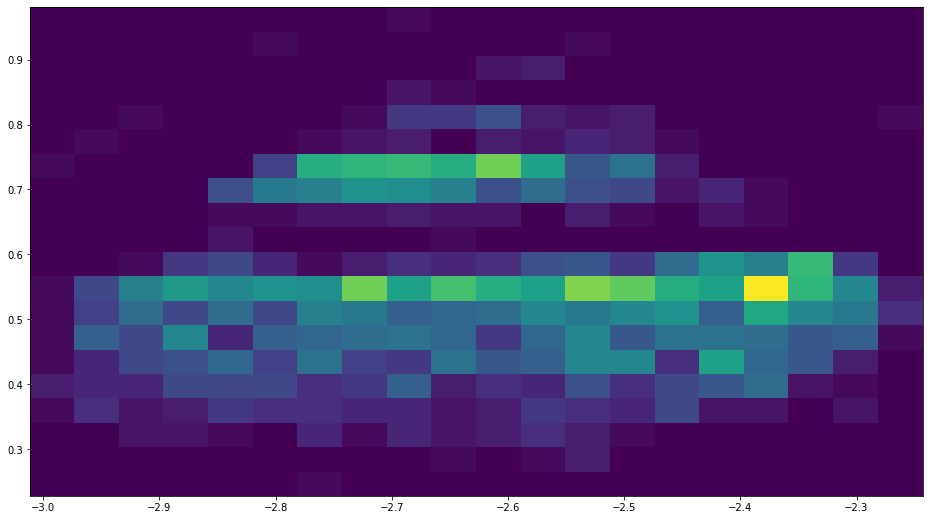

In [13]:
fig = plt.figure(figsize=(16,9))

d = data[(data.theta < 1.0) & (np.abs(data.dt_PIP) < 1.0) & (data.sec == 5)]
plt.hist2d(d.phi, d.theta, bins=20)
plt.show()